In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns

from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu

In [2]:
# loading data
usc_raw_data = pd.read_csv('../Data/USC_HAD_raw.csv')

In [3]:
# only features and label.
usc_unprocessed = usc_raw_data[['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z','label']]

In [4]:
usc_unprocessed.head(5)

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label
0,0.925848,0.331869,-0.27382,-4.849138,1.836862,-0.599354,7
1,0.922414,0.331869,-0.27382,-3.237809,1.829803,-1.399718,7
2,0.922414,0.331869,-0.27382,-1.626481,1.020218,-2.197093,7
3,0.918980,0.328250,-0.27382,0.387679,1.016325,-2.590186,7
4,0.915547,0.339107,-0.27382,2.401839,1.413761,-2.981848,7


In [5]:
# window_size: size of time window
# step: overlapping
# data: dataset
def time_windows(window_size,overlapping,data):
  sigmentation_data_temp = []
  sigmentation_data = []
  sigmentation_label = []
 
  for i in range(0,len(data),overlapping):
    acc_x = data['acc_x'].values[i:i+window_size]
    acc_y = data['acc_y'].values[i:i+window_size]
    acc_z = data['acc_z'].values[i:i+window_size]
    gyro_x = data['gyro_x'].values[i:i+window_size]
    gyro_y = data['gyro_y'].values[i:i+window_size]
    gyro_z = data['gyro_z'].values[i:i+window_size]
    total_label = data['label'].values[i:i+window_size]
    label = Counter(total_label).most_common()[0][0]
    sigmentation_data_temp.append([acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z])
    sigmentation_arr = np.asarray(sigmentation_data_temp)
    sig_size = sigmentation_arr.shape
    if sig_size[2] == window_size:
      sigmentation_arr.reshape(window_size,6)
      sigmentation_data.append(sigmentation_arr)
      sigmentation_label.append(label)
      sigmentation_data_temp = []
    else:
      sigmentation_data_temp = []

  sigmentation_data_arr = np.asarray(sigmentation_data)
  sigmentation_label_arr = np.asarray(sigmentation_label)

  return sigmentation_data_arr,sigmentation_label_arr


In [6]:
# here use Full-non-overlapping
uci_readings,uci_labels = time_windows(128,128,usc_unprocessed)

In [7]:
# in the model, requires 0-n label so make labels from 1-12 into 0-11
uci_labels -1 

array([ 6,  6,  6, ..., 10, 10, 10], dtype=int64)

In [8]:
print('Shape of data:')
print(uci_readings.shape)
print('#######################')
print('Shape of labels: ')
print(uci_labels.shape)

Shape of data:
(21947, 1, 6, 128)
#######################
Shape of labels: 
(21947,)


In [9]:
# use train_test_split to generate train,val and test data
x_train,x_val_test,y_train,y_val_test = train_test_split(uci_readings,uci_labels,test_size = 0.3)
x_val,x_test,y_val,y_test = train_test_split(x_val_test,y_val_test,test_size = 0.3 )

In [10]:
# use torch.TensorDataset to make dataset
train_dataset = TensorDataset(torch.from_numpy(x_train).to(torch.float32),torch.from_numpy(y_train).to(torch.float32))
val_dataset = TensorDataset(torch.from_numpy(x_val).to(torch.float32),torch.from_numpy(y_val).to(torch.float32))
test_dataset = TensorDataset(torch.from_numpy(x_test).to(torch.float32),torch.from_numpy(y_test).to(torch.float32))

In [11]:
# DataLoader generation
train_loader = data.DataLoader(dataset = train_dataset,batch_size = 64,shuffle = True)
val_loader = data.DataLoader(dataset = val_dataset,batch_size = 64,shuffle = True)
test_loader = data.DataLoader(dataset = test_dataset,batch_size = 64,shuffle = False)

In [12]:
images,labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([64, 1, 6, 128]), torch.Size([64]))

In [13]:
# Hyper parameter 
BATCH_SIZE = 64# 32 # 
EPOCHES = 10

In [14]:
def imshow(inp):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Recovery the image
    inp = np.clip(inp, 0, 1) # clip the pixel between 0 and 1
    plt.imshow(inp)
    #if titlle is not None:
        #plt.title(title)
   

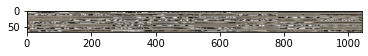

In [15]:
out = torchvision.utils.make_grid(images)
imshow(out)

### LSTM Model

In [16]:
class LSTM_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True)
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        c0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # detach the hidden state to prevent exploding gradient
        out, (hn,cn) = self.lstm(x,( h0.detach(),c0.detach()))# detach 
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t     
        return out

In [17]:
input_dim = 128 # input dimension
hidden_dim = 500 # hidden layers number
layer_dim = 1 
output_dim = 27 + 1 # output dimension

# initialize the model
model_lstm = LSTM_model(input_dim, hidden_dim, layer_dim, output_dim)
# device = torch.device('cuda:0' if torch.cuda.is_available() else  'cpu')

#model = model.to(device)

In [18]:
for i in range(len(list(model_lstm.parameters()))):
    print("parameters: %d" %(i+1))
    print(list(model_lstm.parameters())[i].size())

parameters: 1
torch.Size([2000, 128])
parameters: 2
torch.Size([2000, 500])
parameters: 3
torch.Size([2000])
parameters: 4
torch.Size([2000])
parameters: 5
torch.Size([28, 500])
parameters: 6
torch.Size([28])


In [19]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_lstm.parameters(), lr = learning_rate)

In [ ]:
sequence_dim = 6
lost_list_LSTM = []
accuracy_list = []
iteration_list = [] 
iter = 0

for epoch in range(EPOCHES):
    for i, (images, labels) in enumerate(train_loader):
        model_lstm.train()
        # 32*1*6*128
        images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
        labels = labels.to(torch.int64)
        #labels = labels.to(device)
        # gradient.zero
        optimizer.zero_grad()
        #forward pass
        
        outputs = model_lstm(images)
        # print(output.size(), labels.size(), "pass")
        # loss calc
        loss_lstm = criterion(outputs, labels)
        # backword
        loss_lstm.backward()
        # renew the parameter
        optimizer.step()
        
        iter += 1
        if iter % 200 == 0:
            model_lstm.eval()
            # accuracy
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(train_loader):
                    images = images.view(-1, sequence_dim, input_dim)#.to(device)
                    outputs = model_lstm(images)
                    #print(outputs.size())
                    
                    predict = torch.max(outputs.data, 1)[1]
                    total += labels.size(0)
                    correct += (predict == labels).sum()
            
            accuracy = correct / total * 100
            lost_list_LSTM.append(loss_lstm.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # print the info
            print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_lstm.item(), accuracy))
            

Iter:200,loss:1.3138372898101807,Accuracy:59.308685302734375
Iter:400,loss:1.1081169843673706,Accuracy:67.34800720214844
Iter:600,loss:0.9800200462341309,Accuracy:72.45149993896484
Iter:800,loss:0.6162548661231995,Accuracy:79.0587158203125
Iter:1000,loss:0.5623043775558472,Accuracy:81.23941802978516
Iter:1200,loss:0.6019961833953857,Accuracy:84.0450439453125
Iter:1400,loss:0.7458662390708923,Accuracy:85.19073486328125
Iter:1600,loss:0.41500943899154663,Accuracy:87.54068756103516
Iter:1800,loss:0.4123605787754059,Accuracy:89.05741882324219
Iter:2000,loss:0.39778587222099304,Accuracy:89.98828887939453


In [ ]:
plt.plot(iteration_list,lost_list_LSTM)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("LSTM loss on USC")
plt.show()

In [ ]:
plt.plot(iteration_list,accuracy_list, color = "r")
plt.xlabel("Number of Iteration")
plt.ylabel("Accuracy")
plt.title("LSTM accuracy on USC")
plt.show()

In [ ]:
labels = []
predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_lstm(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
    
    print('Test Accuracy of the basic LSTM model on the USC test features: {} %'.format((correct / total) * 100))

In [ ]:
labels_list = []
predictions = []
classes = [
    'walking forward', 
    'walking left', 
    'walking right',
    'walking upstairs ',
    'walking downstairs',
    'running forward',
    'jumping', 
    'sitting', 
    'standing ', 'sleeping ',
    ' elevator up', 
    'elevator down'
]

with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_lstm(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
        predictions.append(predict)
        labels_list.append(labels)
    
    print('Test Accuracy of the basic LSTM model on the USC test features: {} %'.format((correct / total) * 100))
    
mat = metrics.confusion_matrix(torch.cat(predictions), torch.cat(labels_list))

plt.figure(figsize=(12, 12))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')

### RNN try

In [ ]:
# rnn
# num_feature = 6
# feature_width = 128
class RNN_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        #循环对象
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity = "relu")
        
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # 分离隐藏状态，避免梯度爆炸
        out, hn = self.rnn(x, h0.detach())# detach 分离
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t
            
        return out
        

In [ ]:
input_dim = 128 # input dimension
hidden_dim = 100 # hidden layers number
layer_dim = 2 
output_dim = 27 + 1 # output dimension

# initialize the model
model_rnn = RNN_model(input_dim, hidden_dim, layer_dim, output_dim)
# device = torch.device('cuda:0' if torch.cuda.is_available() else  'cpu')

#model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_rnn.parameters(), lr = learning_rate)
length = (len(list(model_rnn.parameters())))
for i in range(length):
    print("parameters: %d" %(i+1))
    print(list(model_rnn.parameters())[i].size())

In [ ]:
sequence_dim = 6
loss_list = []
accuracy_list = []
iteration_list = [] 
# 24576 = 32*1*6*128
iter =  0
for epoch in range(EPOCHES):
    for i, (images, labels) in enumerate(train_loader):
        model_rnn.train()
        # A batch of data with transfering the RNN input dimention 
        # 32*1*6*128
        images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
        labels = labels.to(torch.int64)
        #labels = labels.to(device)
        # gradient.zero
        optimizer.zero_grad()
        #forward pass
        output = model_rnn(images)

        
        # print(output.size(), labels.size(), "pass")
        # loss calc
        loss_rnn = criterion(output, labels)
        # backword
        loss_rnn.backward()
        # renew the parameter
        optimizer.step()
        
        iter += 1
        if iter % 200 == 0:
            model_rnn.eval()
            # accuracy
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(train_loader):
                    images = images.view(-1, sequence_dim, input_dim)#.to(device)
                    outputs = model_rnn(images)
                    #print(outputs.size())
                    
                    predict = torch.max(outputs.data, 1)[1]
                    total += labels.size(0)
                    correct += (predict == labels).sum()
            
            accuracy = correct / total * 100
            loss_list.append(loss_rnn.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # print the info
            print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_rnn.item(), accuracy))

In [ ]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("RNN")
plt.show()

In [ ]:
plt.plot(iteration_list,accuracy_list, color = "r")
plt.xlabel("Number of Iteration")
plt.ylabel("Accuracy")
plt.title("RNN")
plt.show()

In [ ]:
labels_list = []
predictions = []


with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_rnn(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
        predictions.append(predict)
        labels_list.append(labels)
    
    print('Test Accuracy of the basic RNN model on the USC test features: {} %'.format((correct / total) * 100))
    
mat = metrics.confusion_matrix(torch.cat(predictions), torch.cat(labels_list))

plt.figure(figsize=(12, 12))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')